# Alzheimer's disease (AD) classification by Bayesian Neural Network

+ In this project, we would like to use Bayesian deep learning model to classify Alzheimer's disease (AD) from MRI images. Alzheimer’s disease (AD) is a type of brain disease beginning 20 years or more before symptoms arise with changes in the brain that are unnoticeable to the person affected. Only after years of brain changes do individuals experience noticeable symptoms, such as memory loss and language problems. Alzheimer’s Association estimated that one in 10 people (10 percent) age 65 and older has Alzheimer’s dementia.

+ AD is a complex disease that we do not have a tool to detect it currently. Patients who are diagnosed AD now already had it for decades. This is a part of my projects to find a machine learning tool to help improving detecting early sign of the disease. The goal is to make a Bayesian model to combine different type of patient's information from genes, medical history, ..., etc to improve the prediction. As you can see, I forcus on Bayesian model since having AD is conditional under patients'data about biomarkers, medical history, living styles, ..., just name a few. Only Bayesian models can handle these conditional relationaships, moreover, only Baysian models can provide us some uncertainty levels about their predictions. In order words, when in doubt Bayesian model will tell us "I am not sure". This is a major different from normal machine learning/deep learning method that have been used widely.

+ Here is a basic Bayesian deep learning model to classify AD diseases in 4 categories: "MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented". Our data set is a free dataset downloaded from Kaggle ("https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images"). It is a small dataset, we may not have high accuracy for training, evaluation and testing. The purpose is to show how we use Bayesian deep learning models and its application in image classification.

+ We need the following libraries 

In [171]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import ReduceLROnPlateau
tfd = tfp.distributions
import cv2
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

+ From checking, our dataset is not balance. That means, the number of images for each category is not compatable, e.g., one has 500 images, other has 12 images. To make the data more balance, we are going to augument the images by rotation, shearning, ...

+ Becareful, this method is creating new augumented files. So, you only run it one time. We do this for training data only.

In [172]:
# import os 
# import re

# # os.chdir("./Alzheimer_s Dataset/train/ModerateDemented") 

# train_DATADIR = "./Alzheimer_s Dataset/train/"
# test_DATADIR = "./Alzheimer_s Dataset/test"
# # Importing necessary functions
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
   
# # Initialising the ImageDataGenerator class.
# # We will pass in the augmentation parameters in the constructor.
# datagen = ImageDataGenerator(
#         rotation_range = 10,
#         shear_range = 0.05,
#         zoom_range = 0.05,
#         # horizontal_flip = True,
#         brightness_range = (0.05, 0.5))
# file_list = []
# for f in os.listdir('./Alzheimer_s Dataset/test/ModerateDemented'): 
#     file_list.append(f)


In [173]:
# for f in file_list:
#     # print(f)
#     # Loading a sample image 
#     img = load_img("./Alzheimer_s Dataset/test/ModerateDemented/"+f) 
#     # Converting the input sample image to an array
#     x = img_to_array(img)
#     # Reshaping the input image
#     x = x.reshape((1, ) + x.shape) 
    
#     # Generating and saving 5 augmented samples 
#     # using the above defined parameters. 
#     i = 0
#     for batch in datagen.flow(x, batch_size = 1,
#                             save_to_dir ='./Alzheimer_s Dataset/test/ModerateDemented', 
#                             save_prefix ='ModerateDemented_aug', save_format ='jpg'):
#         i += 1
#         if i > 38:
#             break

In [174]:
# file_list = []
# for f in os.listdir('./Alzheimer_s Dataset/train/MildDemented'): 
#     file_list.append(f)
# for f in file_list:
#     # print(f)
#     # Loading a sample image 
#     img = load_img("./Alzheimer_s Dataset/train/MildDemented/"+f) 
#     # Converting the input sample image to an array
#     x = img_to_array(img)
#     # Reshaping the input image
#     x = x.reshape((1, ) + x.shape) 
    
#     # Generating and saving 5 augmented samples 
#     # using the above defined parameters. 
#     i = 0
#     for batch in datagen.flow(x, batch_size = 1,
#                             save_to_dir ='./Alzheimer_s Dataset/train/MildDemented', 
#                             save_prefix ='MildDemented_aug', save_format ='jpg'):
#         i += 1
#         if i > 3:
#             break

+ We load train and validation dataset into generator by using image_dataset_from_directory feature from keras.

In [175]:
train_DATADIR = "F:\AD_classify\\train"
val_DATADIR = "F:\AD_classify\\val"
test_DATADIR = "F:\AD_classify\\test"
image_size = (160, 160)
batch_size = 32
feature_list = ["Non-demented", "Demented"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_DATADIR,
    # subset="training",
    seed=1337,
    # validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
    # color_mode='grayscale',
    class_names = feature_list,
    label_mode = "categorical",
    # shuffle=True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_DATADIR,
    seed=1337,
    # subset="validation",
    # validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
    class_names = feature_list,
    label_mode = "categorical",
    # color_mode='grayscale',
    # shuffle=True,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_DATADIR,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    # color_mode='grayscale',
    label_mode = "categorical",
    class_names = feature_list,
    shuffle=True,
)

Found 19243 files belonging to 2 classes.
Found 3635 files belonging to 2 classes.
Found 3038 files belonging to 2 classes.


In the following chunk, we get a picture for each type of disease from our dataset. 

In [176]:

AD_images = []
AD_labels = []
j =1
for images, labels in train_ds.take(3):

    for i in range(batch_size):
        
        if (feature_list[np.argmax(labels[i].numpy())] == "Demented" and j==1):
            j = 2
            AD_images.append(images[i].numpy().astype("uint8"))
            AD_labels.append(feature_list[np.argmax(labels[i].numpy())])

        else:
            if (feature_list[np.argmax(labels[i].numpy())] == "Non-demented" and j==2):
                j =1
                AD_images.append(images[i].numpy().astype("uint8"))
                AD_labels.append(feature_list[np.argmax(labels[i].numpy())])





In [177]:
len(AD_images)

51

In [178]:
len(AD_labels)

51

Here are images of the classes of the disease (including augumented images)

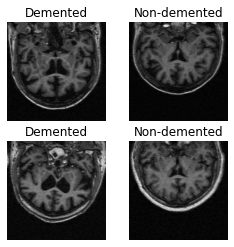

In [179]:
plt.figure(figsize=(4, 4))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(AD_images[i])
    plt.title(AD_labels[i])
    plt.axis("off")
    # print(np.argmax(labels[i].numpy()))
    # print(feature_list[labels[i].numpy()])

In [180]:
train_ds = train_ds.map(lambda x, y: (x/255, y) )
val_ds = val_ds.map(lambda x, y:  (x/255, y))
test_ds = test_ds.map(lambda x,y: (x/255,y))

In [181]:
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.002),
])


In [182]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size[0], image_size[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])


## In the following model, we apply Bayesian models by using both variational Inferences and Monte Carlo dropout techniques. Variationall Inferences will increase the precise of prediction by reducing variance, and MC dropout help us improve the accuracy of prediction and reduce overfit.

+ In Bayesian model, we need to find a balance between point inference and uncertainty inference layers. Uncertainty is helpful in the case the model to predict data outsite its training population by saying "I am not sure", however, if there are too many "I am not sure" in your model, the overall results will be not good since the model lacks confidence about what it predicts.

+ We also do a custom loss function by using KLDivergence-loss for catergory, CategoricalCrossentropy loss, and  KL loss

+ We are interested in accuracy of evaluation set and testing set, so we set up stop early training by save the best weight for highest val_accuracy.

In [183]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001, mode = "auto")
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# inception_model = InceptionV3(input_shape=image_size + (3,), include_top=False, weights="imagenet")
# for layer in inception_model.layers:
    # layer.trainable=False

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log(targets)
# Define custom loss
def custom_loss(layer):
    kl = tf.keras.losses.KLDivergence(
    reduction=tf.keras.losses.Reduction.SUM)
    cce = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)
    


    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return kl(y_true,y_pred) + cce(y_true,y_pred) + sum(model_img.losses)/237  + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        # return  kl(y_true,y_pred) + cce(y_true,y_pred) + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
   
    # Return a function
    return loss


BNN_input = tf.keras.Input(image_size + (3,))
x = tf.keras.layers.Conv2D(256,kernel_size=(3,3),padding="same", activation = 'relu', input_shape=image_size + (3,))(BNN_input)
x = tf.keras.layers.Dropout(0.2)(x, training = True)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128,kernel_size=(3,3),padding="same", activation = 'relu')(x)
# x = tfp.layers.Convolution2DFlipout(32, kernel_size=5, padding='same', activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.5)(x, training = False)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128,kernel_size=(6,6),padding="same", activation = 'relu')(x)
# x = tfp.layers.Convolution2DReparameterization(64, kernel_size=2, padding='same', activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.5)(x, training = True)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding='same', activation=tf.nn.relu)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="sigmoid")(x)
# x = tfp.layers.DenseReparameterization(32, activation="sigmoid")(x)
out = tfp.layers.DenseFlipout(2, activation = 'softmax')(x)
model_img = keras.Model(BNN_input, out, name = "BNN_model")
model_img.compile(loss=custom_loss(out), optimizer="adam", metrics=['accuracy', "AUC"])
model_img.summary()



Model: "BNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 256)     7168      
                                                                 
 dropout_3 (Dropout)         (None, 160, 160, 256)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 53, 53, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 53, 53, 128)       29

c:\Users\phill\tensorflow\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
c:\Users\phill\tensorflow\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


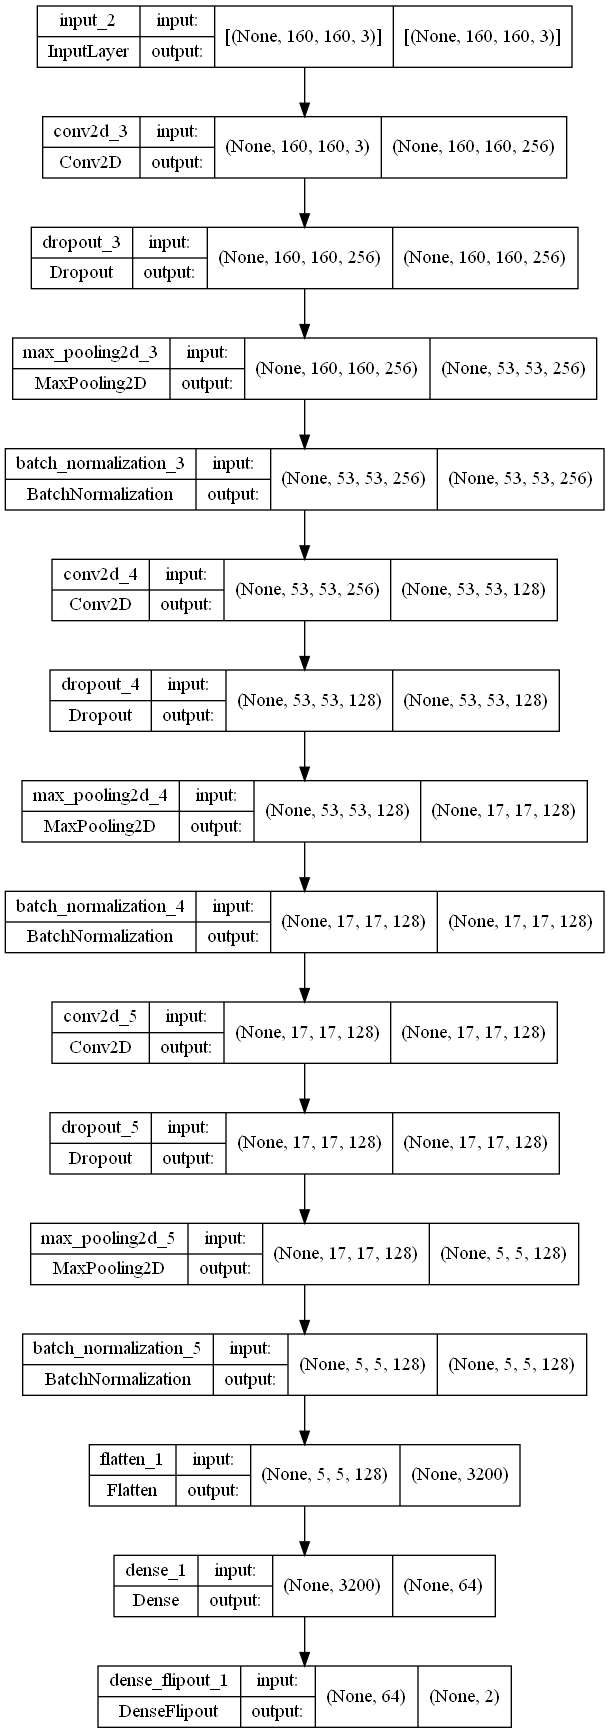

In [184]:
import pydotplus
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
# keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(model_img, to_file='model_test.png', show_shapes=True, show_layer_names=True)

In [185]:
from keras import backend as K
# Define the Keras TensorBoard callback.
logdir="logs/fit/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',  restore_best_weights=True)
# K.set_value(model_vi.optimizer.learning_rate, 0.05)
history = model_img.fit(train_ds, batch_size=batch_size, epochs=20, validation_data=val_ds)


Epoch 1/20
602/602 [==============================] - 163s 269ms/step - loss: 317.9031 - accuracy: 0.7986 - auc: 0.8860 - val_loss: 271.0498 - val_accuracy: 0.9010 - val_auc: 0.9652
Epoch 2/20
602/602 [==============================] - 80s 132ms/step - loss: 227.2009 - accuracy: 0.9549 - auc: 0.9912 - val_loss: 193.7641 - val_accuracy: 0.9436 - val_auc: 0.9879
Epoch 3/20
602/602 [==============================] - 80s 133ms/step - loss: 156.8368 - accuracy: 0.9770 - auc: 0.9967 - val_loss: 126.2416 - val_accuracy: 0.9741 - val_auc: 0.9964
Epoch 4/20
602/602 [==============================] - 79s 131ms/step - loss: 98.2033 - accuracy: 0.9804 - auc: 0.9979 - val_loss: 75.7788 - val_accuracy: 0.9678 - val_auc: 0.9944
Epoch 5/20
602/602 [==============================] - 79s 131ms/step - loss: 54.5704 - accuracy: 0.9809 - auc: 0.9974 - val_loss: 42.7422 - val_accuracy: 0.9494 - val_auc: 0.9904
Epoch 6/20
602/602 [==============================] - 79s 131ms/step - loss: 29.1098 - accuracy: 0

In [186]:
model_img.evaluate(test_ds)

95/95 [==============================] - 23s 184ms/step - loss: 7.9172 - accuracy: 0.9849 - auc: 0.9989


[7.917239189147949, 0.9848584532737732, 0.9988564848899841]

In [187]:
model_img.evaluate(val_ds)

114/114 [==============================] - 26s 201ms/step - loss: 7.9051 - accuracy: 0.9862 - auc: 0.9989


[7.9051289558410645, 0.9862448573112488, 0.9989109039306641]

In [90]:
x_test = test_ds.take(1)

In [91]:
len(x_test)

1

In [92]:
test = list(x_test)

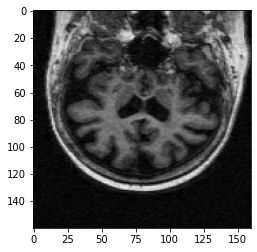

In [95]:
plt.imshow(test[0][0][0])

In [111]:
test[0][1][0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>

In [109]:
list(x_test)[0][1][0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

In [24]:
labels=np.array(["Demented","Non-demented"])

pred_vi=np.zeros((len(x_test),2))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(test[i][0]/255,(20,1,1,1))
  preds=model_img.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)

  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[range(0,len(x_test))],bins=30, density=True,alpha = 0.7)
    # plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    # plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

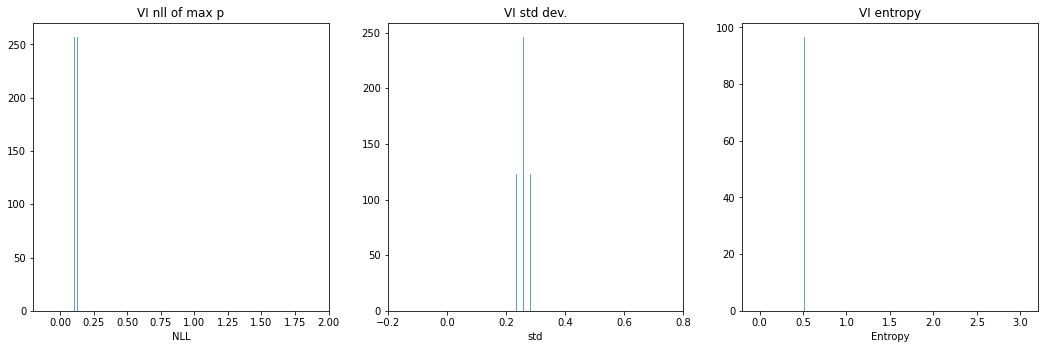

In [26]:
plt.figure(figsize=(18,18))
plt.subplot(3,3,4)
plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,5)
plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
plt.subplot(3,3,6)
plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

In [121]:
test_in = test[0][0][1]/255
test_label = test[0][1][1]
test_in = np.expand_dims(test_in, axis=0)
# test_in.shape = (1,) + x_test[0].shape 



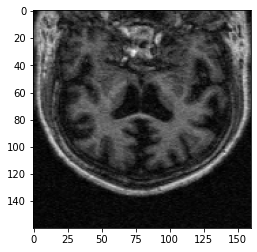

In [122]:
plt.imshow(test[0][0][1])

In [123]:
test_label

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

In [131]:
check = []
for i in range(1000):
    check.append(model_img.predict(test_in))


In [132]:
np.mean(check, axis=0)

array([[0.12315065, 0.8768495 ]], dtype=float32)

In [134]:
np.sqrt(np.var(check, axis=0))

array([[0.19968316, 0.19968313]], dtype=float32)

In [136]:
count_test = 0
x=np.zeros(shape=(1000,2))
for i in range(1000):
  x[i] = model_img.predict(test_in)[0]
  if x[i][0] > 0.5:
    count_test = count_test + 1



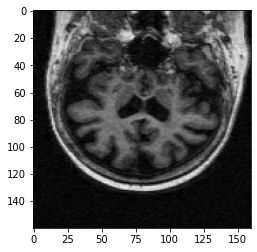

In [120]:
plt.imshow(test[0][0][0])

In [137]:
count_test

50

In [140]:
np.sqrt(np.var(x, axis=0))

array([0.16895138, 0.16895138])

In [139]:
np.mean(x,axis=0)

array([0.09820697, 0.90179303])

(array([739.,  99.,  51.,  28.,  29.,  12.,  16.,  14.,   5.,   7.]),
 array([4.52369386e-06, 9.39069274e-02, 1.87809331e-01, 2.81711735e-01,
        3.75614139e-01, 4.69516542e-01, 5.63418946e-01, 6.57321350e-01,
        7.51223754e-01, 8.45126157e-01, 9.39028561e-01]),
 <BarContainer object of 10 artists>)

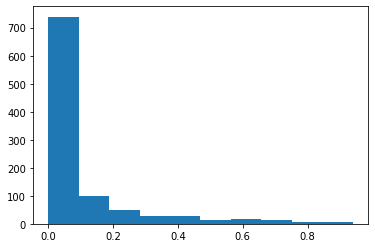

In [141]:
plt.hist(x[:,0])

The histogram above tells us that the probability to have non AD is very small or the probability or have AD is high as you can see in the below histogram

(array([  7.,   5.,  14.,  16.,  12.,  29.,  28.,  51.,  99., 739.]),
 array([0.0609714 , 0.15487381, 0.24877621, 0.34267862, 0.43658103,
        0.53048343, 0.62438584, 0.71828825, 0.81219066, 0.90609306,
        0.99999547]),
 <BarContainer object of 10 artists>)

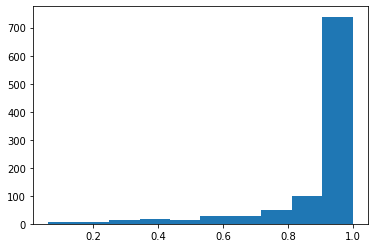

In [142]:
plt.hist(x[:,1])

The followings are graphs of trainings and the performances

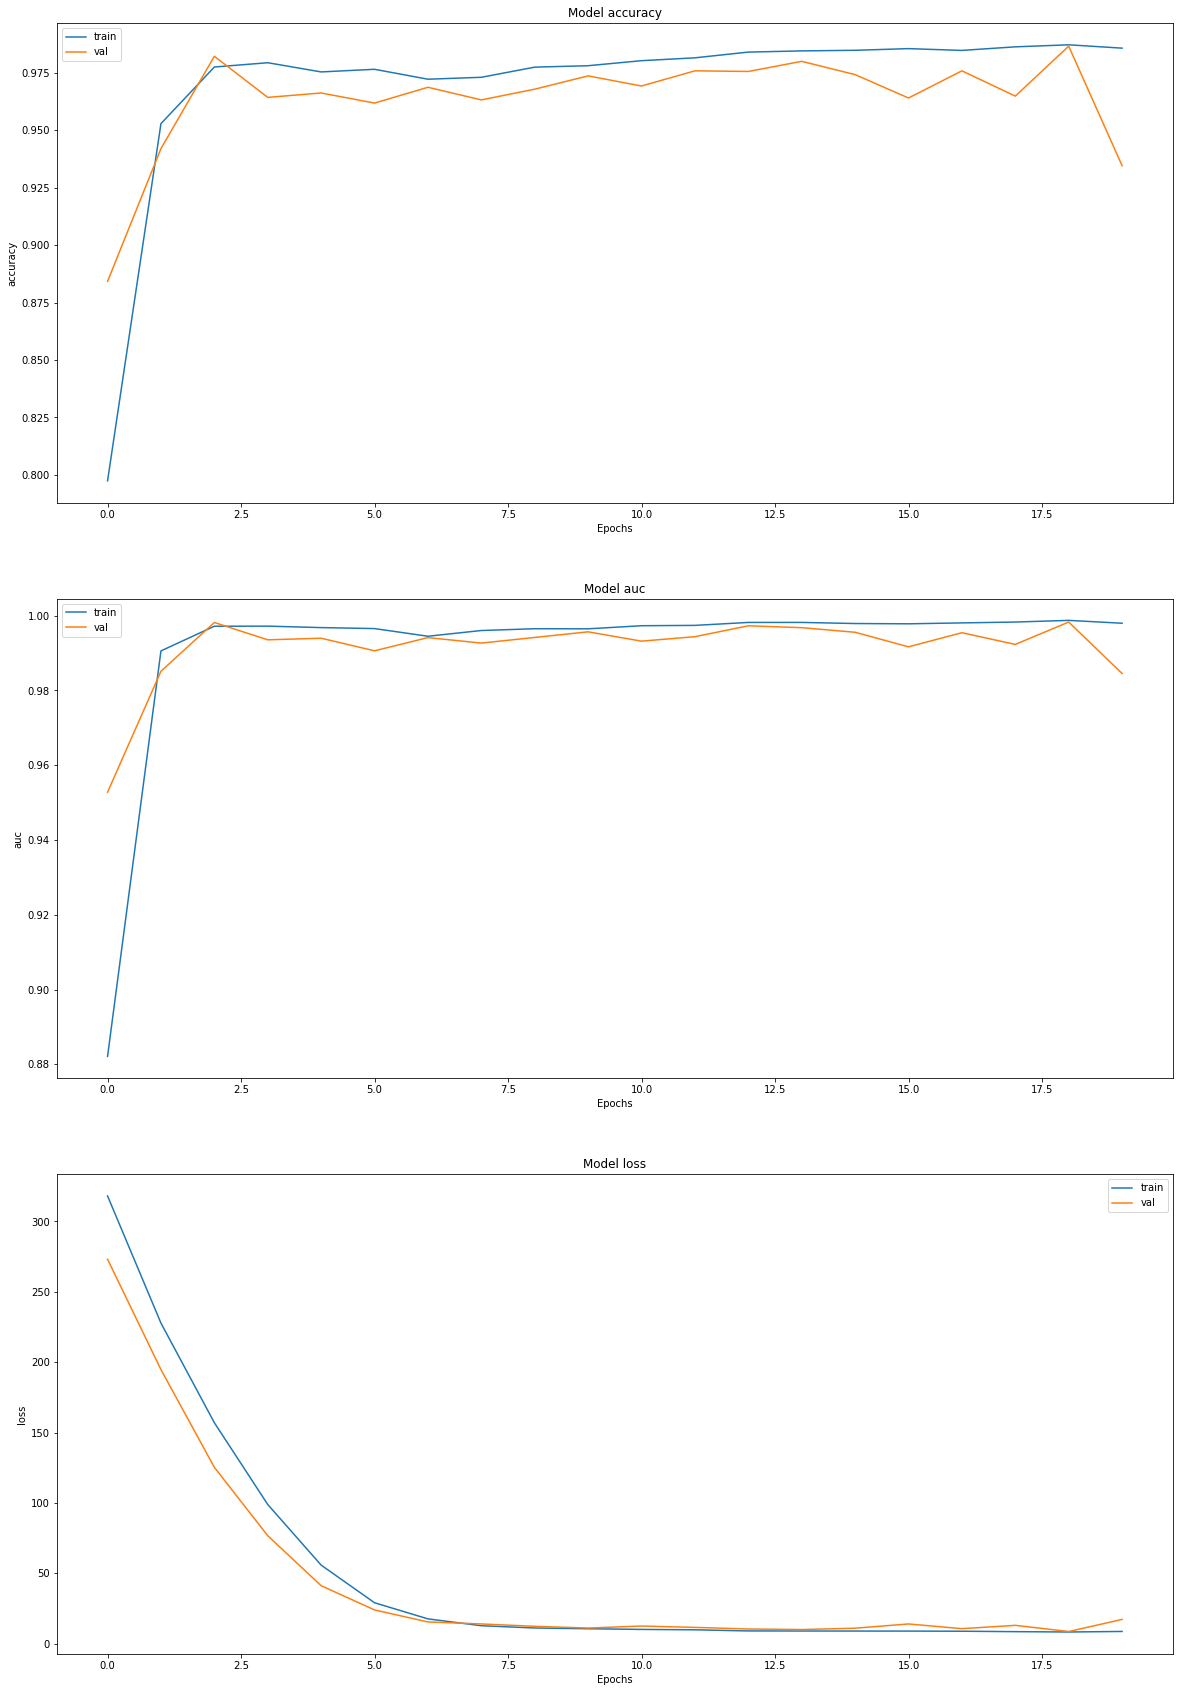

In [35]:
ig, ax = plt.subplots(3, 1, figsize = (20, 30))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

+ The loss function is still decreasing but we don't get the best accuracy. The training may hit overfit after few epoches.

In [36]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


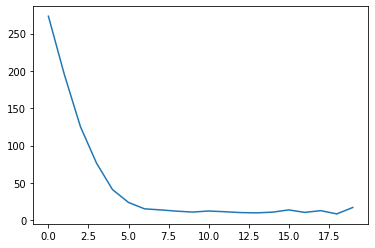

In [37]:
plt.plot(history.history["val_loss"])

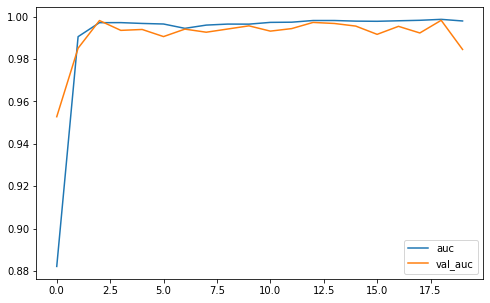

In [38]:
import pandas as pd
pd.DataFrame(history.history).iloc[:,[2,5]].plot(figsize=(8,5))
plt.show()

<AxesSubplot:>

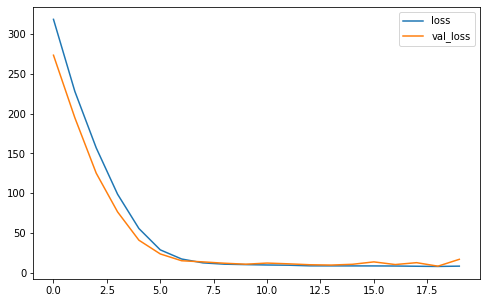

In [39]:
pd.DataFrame(history.history).iloc[:,[0,3]].plot(figsize=(8,5))

# The interesting part of Bayesian deep learning is the ability to recognize the uncertainty of the result for input that is not in the population that the model has seen.

# Make a prediction of image that is not a brain image: In this example, I feed into the model my image of my headshot. Definitely, it is not an image of a brain. What do you expect about the result that our model spit out? The answer is very interesting. Take a look below

In [43]:
# filename_queue = tf.train.([]) #  list of files to read
file_name = tf.io.read_file("C:/Users/phill/Documents/Phi_image.jpeg")
phi_img = tf.io.decode_jpeg(file_name, channels=3)

phi_img = tf.image.resize(phi_img, (160,160))

# let's start with the Imports 
import cv2
import numpy as np

# Read the image using imread function
image = cv2.imread("C:/Users/phill/Documents/Phi_image.jpeg")
# cv2.imshow('Original Image', image)

# let's downscale the image using new  width and height
down_width = 160
down_height = 160
down_points = (down_width, down_height)
resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)

This is my headshot image

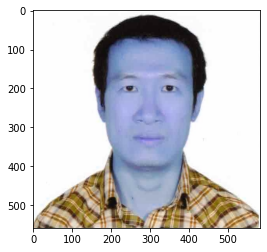

In [44]:
plt.imshow(image)

Need to resize it to the same dimension of training

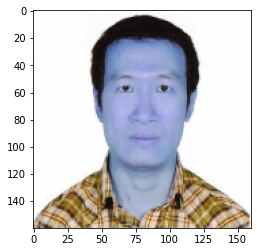

In [45]:
plt.imshow(resized_down)

Since I use mini-batch for training, I need to convert my image to a form that my model can understand to make prediction

In [46]:
phi_img = np.expand_dims(resized_down, axis=0)
phi_img.shape

(1, 160, 160, 3)

Since the model is probabilistics, I need to run the model many times to get the correct answer. I run over 2000 times.

In [144]:
it = 2000
pred_phi=np.zeros([it,2])
for i in range(it):
    pred_phi[i] = model_img.predict(phi_img)

If the value is > 0.5, it is corresponding to AD

In [158]:
dem = []
count = 0
for i in range(it):
    dem.append(pred_phi[i][1])
    if pred_phi[i][0] > 0.5:
        count = count + 1

In [159]:
count

1413

The probability that our model predict AD for the headshot image

In [146]:
mean_value = count/it
mean_value

0.7065

In [161]:
np.mean(pred_phi, axis=0)

array([0.70525535, 0.29474465])

The error of prediction

In [162]:
np.sqrt(np.var(pred_phi,axis=0))

array([0.41751075, 0.41751075])

Next, the following histogram tell us that how uncertain our model make its decision. Some time, it said the headshot image is corressponding to AD but it also said it may not related to AD. This also is confirmed by the results with probability of having AD is 0.71 but the standard error is 0.4.

(array([1265.,   48.,   43.,   30.,   27.,   33.,   23.,   38.,   53.,
         440.]),
 array([5.04876098e-18, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

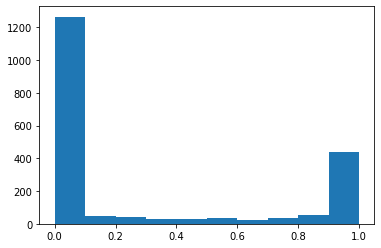

In [160]:
import matplotlib.pyplot as plt
plt.hist(dem)

Our model successfully identify some uncertainty that it should be when there is some doubt about the inputs.

## Next, we take a look at Frequentist model.

In [24]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=3, min_lr=0.001, mode = "auto")
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# inception_model = InceptionV3(input_shape=image_size + (3,), include_top=False, weights="imagenet")
# for layer in inception_model.layers:
#     layer.trainable=False

# def negative_loglikelihood(targets, estimated_distribution):
#     return -estimated_distribution.log(targets)
# Define custom loss
def custom_loss_fs(layer):
    kl = tf.keras.losses.KLDivergence(
    reduction=tf.keras.losses.Reduction.SUM)
    cce = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)
    


    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        # return kl(y_true,y_pred) + cce(y_true,y_pred) + sum(model_vi.losses)/237 + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        return  kl(y_true,y_pred)/237 + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
   
    # Return a function
    return loss

model_fs = tf.keras.Sequential([
# tfp.layers.Convolution2DFlipout(120,kernel_size=(6,6),padding="same", activation = 'relu', input_shape=image_size + (3,)),
tf.keras.layers.Conv2D(64,kernel_size=(6,6),padding="same", activation = 'relu', input_shape=image_size + (3,)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64,kernel_size=(4,4),padding="same", activation = 'relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32,kernel_size=(4,4),padding="same", activation = 'relu'),
tf.keras.layers.MaxPooling2D((3,3)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32,kernel_size=(2,2),padding="same", activation = 'relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(32, activation = 'relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(16, activation = 'relu'),
tf.keras.layers.Dense(4, activation = 'softmax'),
])

# kl = sum(model.losses)
# loss =  kl
# train_op = tf.keras.optimizers.Adam(loss)



model_fs.compile(loss=custom_loss_fs(layer), optimizer="sgd", metrics=['accuracy', "AUC"])
model_fs.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 250, 250, 64)      6976      
_________________________________________________________________
dropout_7 (Dropout)          (None, 250, 250, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 125, 125, 64)      256       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 125, 125, 64)      65600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 125, 125, 64)     

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history1 = model_fs.fit(train_ds, batch_size=batch_size, epochs=40, validation_data=val_ds, callbacks=[callback])

Epoch 1/40
237/237 [==============================] - 49s 204ms/step - loss: 0.9578 - accuracy: 0.8681 - auc: 0.9796 - val_loss: 1.4862 - val_accuracy: 0.4796 - val_auc: 0.7818
Epoch 2/40
237/237 [==============================] - 49s 206ms/step - loss: 0.9059 - accuracy: 0.9070 - auc: 0.9885 - val_loss: 1.2917 - val_accuracy: 0.5844 - val_auc: 0.8574
Epoch 3/40
237/237 [==============================] - 49s 207ms/step - loss: 0.8747 - accuracy: 0.9255 - auc: 0.9921 - val_loss: 1.6389 - val_accuracy: 0.4140 - val_auc: 0.7143
Epoch 4/40
237/237 [==============================] - 50s 208ms/step - loss: 0.8465 - accuracy: 0.9448 - auc: 0.9952 - val_loss: 1.0560 - val_accuracy: 0.7777 - val_auc: 0.9457
Epoch 5/40
237/237 [==============================] - 49s 207ms/step - loss: 0.8233 - accuracy: 0.9584 - auc: 0.9974 - val_loss: 1.3600 - val_accuracy: 0.5993 - val_auc: 0.8418
Epoch 6/40
237/237 [==============================] - 50s 211ms/step - loss: 0.8149 - accuracy: 0.9622 - auc: 0.997

In [27]:
model_fs.evaluate(val_ds)

60/60 [==============================] - 6s 88ms/step - loss: 0.7800 - accuracy: 0.9846 - auc: 0.9995


[0.7800167798995972, 0.9846479892730713, 0.9995205998420715]

In [28]:
model_fs.evaluate(test_ds)

55/55 [==============================] - 5s 89ms/step - loss: 1.3639 - accuracy: 0.5810 - auc: 0.7978


[1.3638579845428467, 0.5809798240661621, 0.7977732419967651]

+ We can see that, this model gave us a big gap between accuracy of validation and test set. Although the accuracy on the test set is higher than Bayesian model, we notice thaat the AUC is actually lower for frequentist model. It means that Bayesian model is still better for prediction in reducing false results.

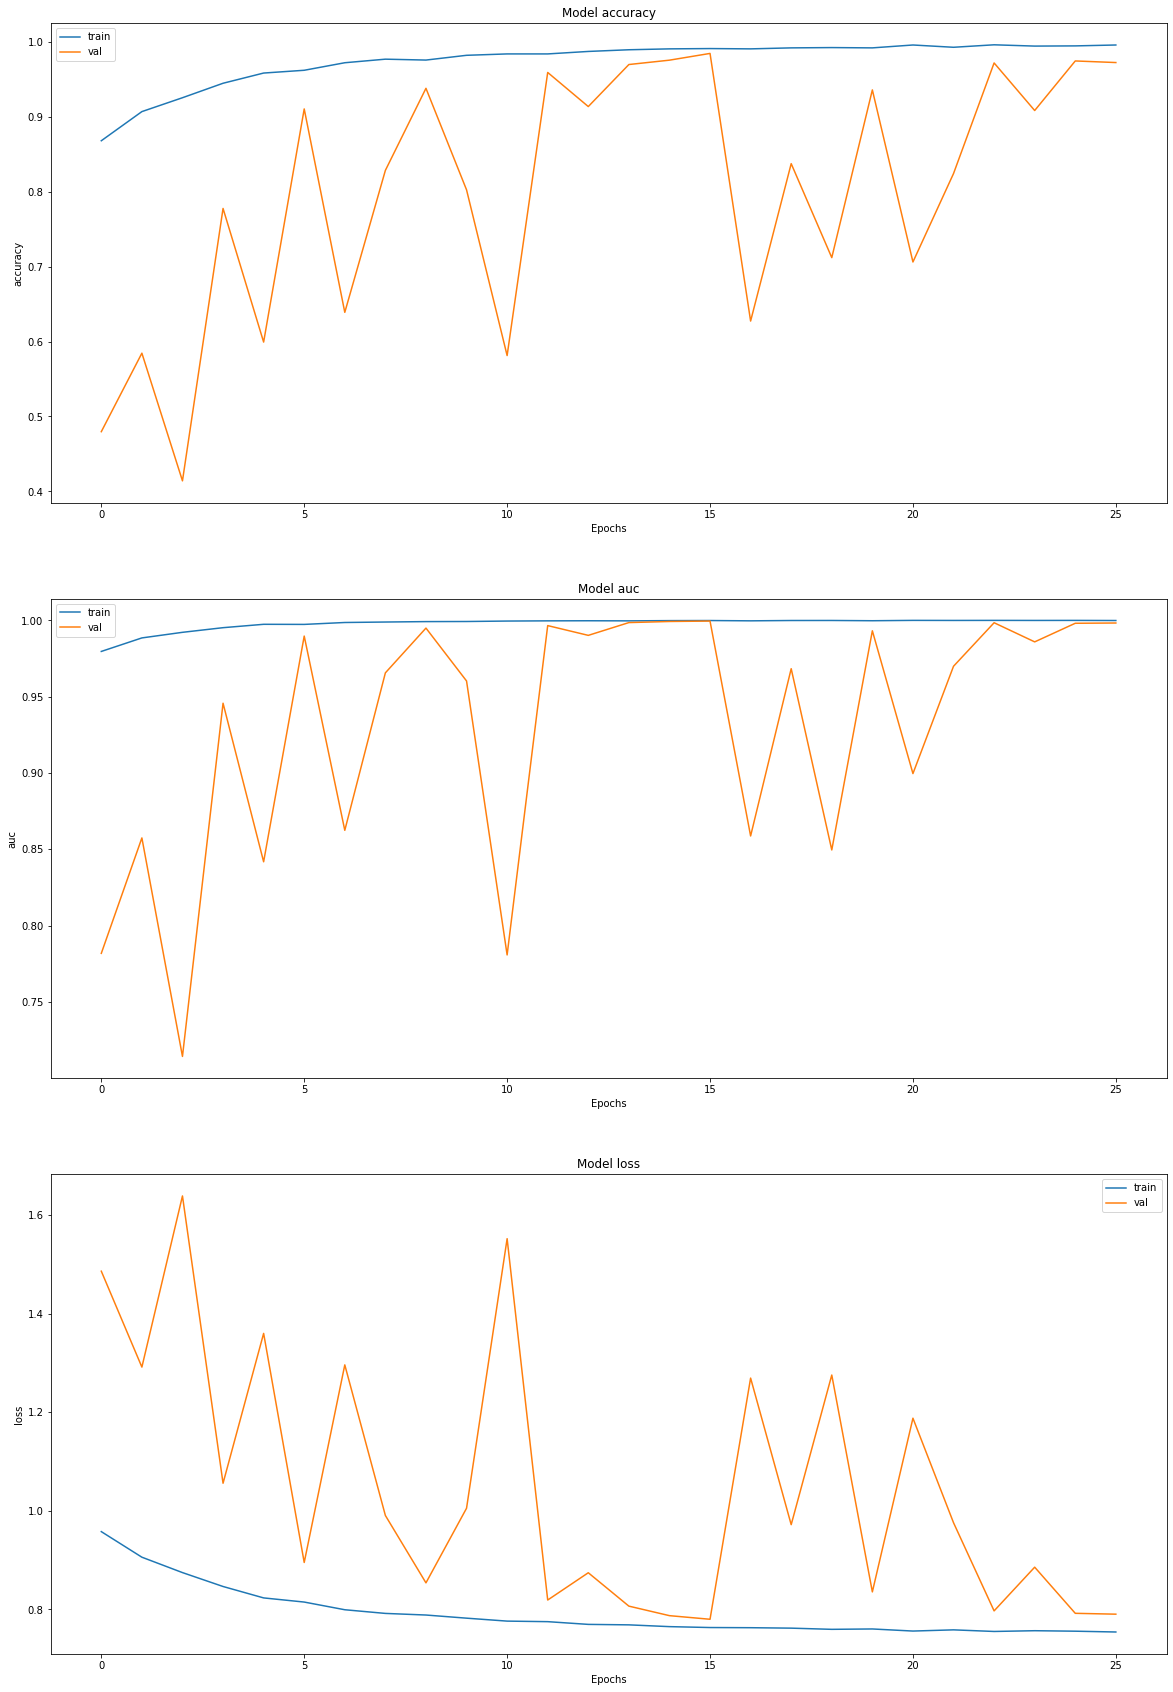

In [30]:
fig, ax = plt.subplots(3, 1, figsize = (20, 30))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(history1.history[metric])
    ax[i].plot(history1.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])